Sources:
- [Primary energy consumption](https://ourworldindata.org/energy-production-consumption#total-energy-consumption)
- [Population](https://ourworldindata.org/grapher/population-of-all-world-regions-including-the-un-projection-until-2100?country=OWID_WRL~Asia~Africa~Europe~South+America~Northern+America)
- [CO<sub>2</sub> emissions](https://ourworldindata.org/grapher/annual-co2-emissions-per-country?tab=chart&country=~OWID_WRL)
- [Greenhouse gas emissions](https://ourworldindata.org/grapher/total-ghg-emissions?tab=chart&country=~OWID_WRL)
- [GDP](https://ourworldindata.org/grapher/gross-domestic-product)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,6)

In [39]:
df_co2 = pd.read_csv('input/annual-co2-emissions-per-country.csv')
df_e = pd.read_csv('input/primary-energy-cons.csv')
df_pop = pd.read_csv('input/population-of-all-world-regions-including-the-un-projection-until-2100.csv')
df_gdp = pd.read_csv('input/gross-domestic-product.csv')

In [40]:
df_co2['Annual CO2 emissions'] = df_co2['Annual CO2 emissions'] * 10**6 # change unit from t to g
df_e['Primary energy consumption (kWh)'] = df_e['Primary energy consumption (TWh)'] * 10**9

In [41]:
def selectCountry(df, country):
    mask = df['Entity'] == country
    return df[mask]

def selectYear(df, year):
    mask = df['Year'] == year
    return df[mask]

def getVariation(df, var):
    variation = 100 * np.diff(df[var]) / df[var].to_numpy()[0:-1]
    df[var+' variation'] = np.insert(variation, 0, None)
    return df

def plotEvolution(df1, df2, var, unit, var_nom, var_denom, rolling_period=5, goal_2050=None, variation_2050=None):
    df_merge = pd.merge(df1, df2, on='Year')
    df_merge[var] = df_merge[var_nom] / df_merge[var_denom]
    df_merge[var] = df_merge[var].rolling(rolling_period).mean()
    df_merge = getVariation(df_merge, var)

    fig, ax1 = plt.subplots()
    ax1.plot(df_merge['Year'], df_merge[var], color='black')
    ax1.set_ylabel(f'{var} ({unit})', color='black', fontsize=18)
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.set_ylim(0,None)

    ax2 = ax1.twinx()
    ax2.plot(df_merge['Year'], df_merge[f'{var} variation'], color='red')
    ax2.set_ylabel(f'{var} variation (%)', color='red', fontsize=18)
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.grid()   
    
    if goal_2050 is not None:
        lns1 = ax1.plot([df_merge['Year'].iloc[-1], 2050], [df_merge[var].iloc[-1], goal_2050],
                         '--', color='black', label='Goal 2050')
        proj_2050 = df_merge[var].iloc[-1] * (1 + variation_2050/100)**(2050-df_merge['Year'].iloc[-1])
        lns2 = ax1.plot([df_merge['Year'].iloc[-1], 2050], [df_merge[var].iloc[-1], proj_2050],
                          ':', color='black', label='Projection 2050')
        lns3 = ax2.plot([df_merge['Year'].iloc[-1], 2050], [variation_2050, variation_2050],
                         ':', color='red', label='Projected variation')
        
        lns = lns1+lns2+lns3
        labs = [l.get_label() for l in lns]      
        ax1.legend(lns, labs)


In [93]:
country = 'France'
df_co2_country = selectCountry(df_co2, country)
df_e_country = selectCountry(df_e, country)
df_pop_country = selectCountry(df_pop, country)
df_gdp_country = selectCountry(df_gdp, country)

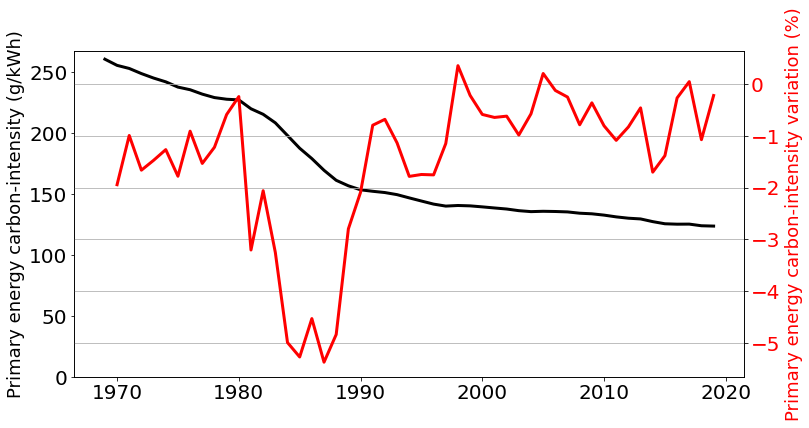

In [94]:
plotEvolution(df_co2_country, df_e_country, 'Primary energy carbon-intensity',
             'g/kWh', 'Annual CO2 emissions', 'Primary energy consumption (kWh)')

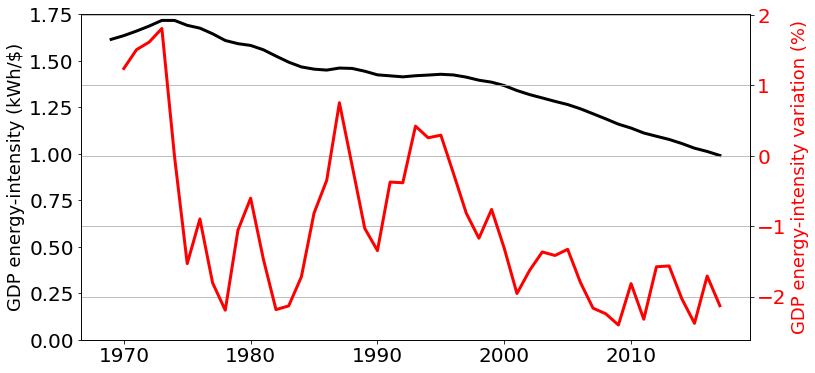

In [61]:
plotEvolution(df_e_country, df_gdp_country, 'GDP energy-intensity', 'kWh/$',
              'Primary energy consumption (kWh)', 'GDP (constant 2010 US$)')

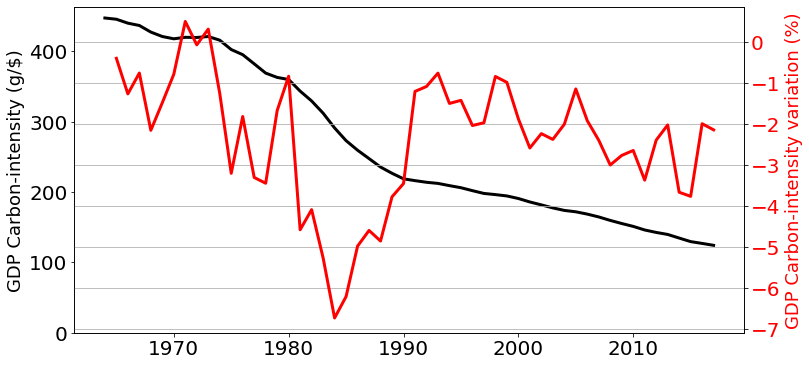

In [62]:
plotEvolution(df_co2_country, df_gdp_country, 'GDP Carbon-intensity', 'g/$',
              'Annual CO2 emissions', 'GDP (constant 2010 US$)')

In [63]:
from ipywidgets import interact
import ipywidgets as widgets

In [98]:
@interact

def projection(country=widgets.Dropdown(options=df_co2['Entity'].unique(), value='France'),
               co2_factor=widgets.FloatSlider(min=0, max=6, step=0.2, value=3),
               population_factor=widgets.FloatSlider(min=0.5, max=1.5, step=0.1, value=1.1),
               gdp_growth=widgets.FloatSlider(min=-3, max=3, step=0.1, value=2),
               variation=widgets.FloatSlider(min=-6, max=-1, step=0.1, value=-2.5)):

    df_co2_country = selectCountry(df_co2, country)
    df_e_country = selectCountry(df_e, country)
    df_pop_country = selectCountry(df_pop, country)
    df_gdp_country = selectCountry(df_gdp, country)
    
    year = df_gdp_country['Year'].max()

    co2 = float(selectYear(df_co2_country, year)['Annual CO2 emissions'])
    gdp = float(selectYear(df_gdp_country, year)['GDP (constant 2010 US$)'])
    pop = float(selectYear(df_pop_country, year)['Estimates, 1950 - 2020: Total population by broad age group, both sexes combined (thousands) - Total'])
    gdp_pop = gdp/pop
    
    gdp_pop_2050 = gdp_pop * (1 + gdp_growth/100)**(2050-year)
    pop_2050 = pop * population_factor
    co2_2050 = co2 / co2_factor
    
    co2_gdp_2050 = co2_2050 * (1/pop_2050) * (1/gdp_pop_2050)
    
    print(f'Parameter: {year} value --> 2050 value')
    print(f'CO2 emissions (Mt): {co2/10**12:.1f} --> {co2_2050/10**12:.1f}')
    print(f'Population (Millions): {pop/10**6:.1f} --> {pop_2050/10**6:.1f}')
    print(f'GDP per capita ($): {gdp_pop:.0f} --> {gdp_pop_2050:.0f}')
    print('')
    print(f'GDP carbon-intensity (g/$): {co2/gdp:.1f} --> {co2_gdp_2050:.1f}')
    
    plotEvolution(df_co2_country, df_gdp_country, 'GDP Carbon-intensity', 'g/$',
                  'Annual CO2 emissions', 'GDP (constant 2010 US$)',
                  goal_2050=co2_gdp_2050, variation_2050=variation)

interactive(children=(Dropdown(description='country', index=74, options=('Afghanistan', 'Africa', 'Albania', '…